In [1]:
import model_lib
import chalenge1000
import numpy as np
import collections
import functools
import operator
from operator import itemgetter
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

In [4]:
class perf_model(object):
	import model_lib
	import chalenge1000
	import numpy as np
	import collections
	import functools
	import operator
	from operator import itemgetter
	import pandas
	import matplotlib.pyplot as plt
	from sklearn.model_selection import train_test_split
	from IPython.display import display, HTML
	"""docstring for perf_model"""
	def __init__(self, categories, model_parameters, test_size):
		self.categories = categories
		self.model_parameters = model_parameters
		self.test_size = test_size
		self.df = self.get_df()


	def get_df(self):
		lemm = lambda x: model_lib.Lemm(x,file = 'stopwords_agri.txt').X
		lexic = lambda x: ' '.join([a for a,b in collections.Counter(x.split()).most_common(10000)])
		word_count = lambda x: {a:b for a,b in collections.Counter(x.split()).most_common(10000)}		

		challenge = chalenge1000.Native()
		df_cat_temp = challenge.temp
		
		df_trad = challenge.trad
		df_trad['corpus'] = df_trad[['prez_struc', 'prez_produit_struc']].agg(sum, axis = 1)
		df_trad['corpus_lemm'] = df_trad['corpus'].map(lemm)
		df_trad['lexic_lemm'] = df_trad['corpus_lemm'].map(lexic)
		df_trad['word_weight'] = df_trad['corpus_lemm'].map(word_count)

		df = df_trad.join(df_cat_temp)

		return df

	def lexic_extractor(self):
		lex1 = collections.Counter(self.df[self.df['cat_struc']== self.categories[0]]['lexic_lemm'].agg(sum, axis=0).split()).most_common(5000)
		lex2 = collections.Counter(self.df[self.df['cat_struc']== self.categories[1]]['lexic_lemm'].agg(sum, axis=0).split()).most_common(5000)

		len_cat1 = len(self.df[self.df['cat_struc']==self.categories[0]])
		len_cat2 = len(self.df[self.df['cat_struc']==self.categories[1]])
    
		counter_cat1 = list({(a,b*100/len_cat1) for a,b in lex1}.union({(k,0) for k,l in lex2 if k not in [a for a,b in lex1]}))
		counter_cat2 = list({(a,b*100/len_cat2) for a,b in lex2}.union({(k,0) for k,l in lex1 if k not in [a for a,b in lex2]}))

		vocab = [a for a,b in counter_cat1]
    
		id = operator.itemgetter(0)
    
		weight_cat1 = self.df[self.df['cat_struc']== self.categories[0]]['word_weight']
		weight_cat2 = self.df[self.df['cat_struc']== self.categories[1]]['word_weight']
    
		vocab_weight_cat1 = [(key, value/len_cat1) for key, value in dict(functools.reduce(operator.add, map(collections.Counter, weight_cat1))).items()]
		vocab_weight_cat1  = list({i for i in vocab_weight_cat1 if id(i) in vocab}.union({(k, 0) for k in vocab if k not in [a for a,b in vocab_weight_cat1]}))

		vocab_weight_cat2 = [(key, value/len_cat2) for key, value in dict(functools.reduce(operator.add, map(collections.Counter, weight_cat2))).items()]
		vocab_weight_cat2  = list({i for i in vocab_weight_cat2 if id(i) in vocab}.union({(k, 0) for k in vocab if k not in [a for a,b in vocab_weight_cat2]}))
    
		id_counter_cat2 = {id(rec): rec[1:] for rec in counter_cat2}
		id_vocab_weight_cat1 = {id(rec): rec[1:] for rec in vocab_weight_cat1}
		id_vocab_weight_cat2 = {id(rec): rec[1:] for rec in vocab_weight_cat2}
    
		merged = [i + id_counter_cat2[id(i)] for i in counter_cat1 if id(i) in id_counter_cat2]
		merged = [i + id_vocab_weight_cat1[id(i)] for i in merged if id(i) in id_vocab_weight_cat1]
		merged = [i + id_vocab_weight_cat2[id(i)] for i in merged if id(i) in id_vocab_weight_cat2]

		keyword_map = pandas.DataFrame(merged, columns = ['keyword','cat1', 'cat2', 'weight_cat1', 'weight_cat2'])
    
		def produit(x,y):
			return x*(y+1)
    
		keyword_map['score_cat1'] = keyword_map.apply(lambda x: produit(x['cat1'], x['weight_cat1']), axis = 1)
		keyword_map['score_cat2'] = keyword_map.apply(lambda x: produit(x['cat2'], x['weight_cat2']), axis = 1)
		keyword_map['difference'] = abs(keyword_map['score_cat1'] - keyword_map['score_cat2'])
		keyword_map.sort_values('difference', ascending = False)
    
		#percentile = pandas.DataFrame(keyword_map['difference'].quantile(np.linspace(.01, 1, 99, 00)))
		#percentile['lag_diff'] = percentile.diff(axis = 0)
    
		pct = []
		for i in range(1, 100):
			i = i/100
			j = i -0.01
			temp = keyword_map['difference'].quantile(i)
			diff = temp - keyword_map['difference'].quantile(j)
			if i ==0.01: 
				pct.append([i, temp, abs(temp)/2])
			else: 
				pct.append([i, temp, diff])
		pct1 = pandas.DataFrame(pct, columns=['a', 'b', 'c'])
		
		print(plt.scatter(pct1.index, pct1['c']))
    
		select = pct1[pct1['c']>pct1['c'].mean()]['a'].values.tolist()
		
		print(select)
    
		def cible(liste):
			for i in liste:
				if i<=0.5:
					next
				else:
					return i
					break
    
		quant = cible(select)
		print('Quantile sélectionné :', quant)
    
		lexic_model = [i for i in keyword_map[keyword_map['difference']>keyword_map['difference'].quantile(quant)]['keyword']]    
		print('Longueur du lexique :',len(lexic_model))
    
		dic_word_weight = keyword_map[['keyword', 'score_cat1', 'score_cat2']].set_index('keyword').T.to_dict('list')
    
		return lexic_model, dic_word_weight

	def perf_lda(self, model_param):

		text_corpus_label = self.df[self.df['cat_struc'].isin(self.categories)][['corpus_lemm','cat_struc']] 
		
		test,train = train_test_split(text_corpus_label, test_size = self.test_size)
		
		train = train['corpus_lemm']
		test = test['corpus_lemm']
    
		model = model_lib.Models(**model_param)
    
		models = model.run_model_LDA(train.values.tolist())

		predict = pandas.DataFrame(model.reverse_lda(test.values.tolist(), models) , index =test.index)
		#display(predict)
    
		return models['LDA'], predict

	def topic_to_category(self, components, vocab_weight):
		topic_category = {}
		for i in range(2):
			words = components['Topic {}'.format(i)]
			cat1 = []
			cat2 = []
			for j in words: 
				if j in vocab_weight.keys():
					cat1.append(vocab_weight[j][0])
					cat2.append(vocab_weight[j][1])
			cat1 = sum(cat1)
			cat2 = sum(cat2)
			topic_category[i] = cat1 - cat2
    
		if topic_category[0]>topic_category[1]:
			topic_category[0]= self.categories[0]
			topic_category[1]= self.categories[1]
		else:
			topic_category[0]= self.categories[1]
			topic_category[1]= self.categories[0]
        
		return topic_category

	def precision(self, predict, topic_category):
    
		def get_topic(e):
			if e >0:
				return topic_category[0]
			if e<0:
				return topic_category[1]
    
		def true_positve(a,b):
			if a == b:
				return 1
			else:
				return 0

		precision = predict.join(self.df['cat_struc'])
		precision[0] = precision[0]*100
		precision[1] = precision[1]*100
		precision['topic'] = precision[0]-precision[1]
		#display(predict)

		precision['predict_label'] = precision['topic'].map(get_topic)
		#display(predict)

		precision['classification_kpi'] = precision.apply(lambda x: true_positve(x['cat_struc'],x['predict_label']), axis= 1)
		#display(predict)

		cat0 = precision[precision['cat_struc'] == self.categories[0]]
		cat1 = precision[precision['cat_struc'] == self.categories[1]]

		#print(model_parameters)
    
		print('\nPrécision vrai positif catégorie {}: {}'.format(categories[0],cat0['classification_kpi'].sum()/len(cat0)*100))
    
		print('\nPrécision vrai positif catégorie {}: {}'.format(categories[1],cat1['classification_kpi'].sum()/len(cat1)*100))
    
		#model_parameters.update({'precision':agri['classification_kpi'].sum()/len(agri)*100, 'vocabulaire': models['LDA']['feature_names']})
		#errors = agri[agri['classification_kpi'] == 0].sort_values('topic')
		#collections.Counter(' '.join(errors.join(text_corpus)['collection_counter'].values.tolist()).split()).most_common(10)
		#return model_parameters, agri, other, models['LDA']
    
		return precision

	def operation(self):
		vocab, vocab_weight = self.lexic_extractor()
		model_param = self.model_parameters
		model_param['vocabulary'] = vocab

		models, predict = self.perf_lda(model_param)

		components = models['components']

		topic_category = self.topic_to_category(components, vocab_weight)

		precis = self.precision(predict, topic_category)

		return models, predict, precis
		

In [5]:
categories = ['agriculture', 'media']
model_parameters = {'n_components' : 2, 'n_top_words' : 500, 'n_features' : 20000, 'doc_topic_prior':0.1}
test_size = 0.8

perf = perf_model(categories, model_parameters, test_size)

[0.81, 0.83, 0.84, 0.86, 0.87, 0.89, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
Quantile sélectionné : 0.81
Longueur du lexique : 1126
Extracting tf features for LDA...
done in 0.062s.

Fitting LDA models with tf features, n_features=20000...
done in 0.823s.

Topics in LDA model:
Topic #0: product farmer food production farm agricultural market produce make service agriculture organic local water fruit waste sustainable woman vegetable fish management crop rural technology order training young develop plant city urban access producer platform oil natural health land social environment feed cassava energy field marketing promote chain fresh harvest honey farming income seed data train animal economic mobile agribusiness fertilizer soil industry environmental digital meet organization team source household child practice innovation application agri school dry information moringa design free flour climate range creation material livestock job scale solar chemical security healt

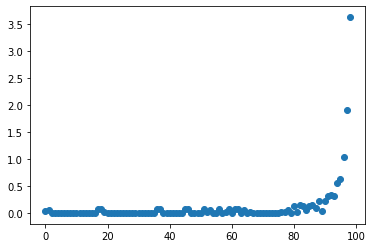

In [6]:
a,b,c = perf.operation()